## New version of aRchaic (Gossling + Sherpa + HGDP)

We apply the new version of aRchaic that takes into account the strand and strand breaks information. We try to investigate how big a role strand breaks and strand information play in clustering the ancient samples. We analyse the pooled data of ancient and controls from Gossling et al 2017, Sherpa data from Di Rienzo lab and the HGDP moderns data.

In [1]:
options(warn=-1)
library(aRchaic)
library(CountClust)
library(maptpx)
library(grid)
library(gridBase)

Loading required package: ggplot2


In [2]:
gossling_data <- get(load("../processed_data/annagosling2016-strand-flank.rda"))
gossling_club <- club_signature_counts(gossling_data, flanking_bases = 2)
gossling_club <- gossling_club[-28,];
gossling_filtered <- filter_signatures_by_location(gossling_club, max_pos=20)
gossling_filtered_2 <- cbind(gossling_filtered, gossling_club[,(dim(gossling_club)[2]-7):dim(gossling_club)[2]])


sherpa_data <- get(load("../processed_data/sherpa2017-strand-flank.rda"))
sherpa_club <- club_signature_counts(sherpa_data, flanking_bases = 2)
sherpa_filtered <- filter_signatures_by_location(sherpa_club, max_pos = 20)
sherpa_filtered_2 <- cbind(sherpa_filtered, sherpa_club[,(dim(sherpa_club)[2]-7):dim(sherpa_club)[2]])


hgdp_data <- get(load("../processed_data/HGDPmoderns-counts-table-strand-flank.rda"))
hgdp_club <- club_signature_counts(hgdp_data, flanking_bases = 2)
hgdp_filtered <- filter_signatures_by_location(hgdp_club, max_pos = 20)
hgdp_filtered_2 <- cbind(hgdp_filtered, hgdp_club[,(dim(hgdp_club)[2]-7):dim(hgdp_club)[2]])


pooled_names <- intersect(colnames(gossling_filtered_2),
                          intersect(colnames(sherpa_filtered_2),
                          colnames(hgdp_filtered_2)))

indices1 <- match(pooled_names, colnames(gossling_filtered_2))
indices2 <- match(pooled_names, colnames(sherpa_filtered_2))
indices3 <- match(pooled_names, colnames(hgdp_filtered_2))

pooled_dat <- rbind(gossling_filtered_2[, indices1],
                    sherpa_filtered_2[, indices2],
                    hgdp_filtered_2[, indices3])

In [4]:
## defining the labels of the samples from different sources

names <- rownames(gossling_filtered);
control_indices <- c(grep("EXN", names), grep("Libneg", names), grep("PCRneg", names))

labs <- character();
labs <- rep("ancient", dim(gossling_club)[1])
labs[control_indices] <- "controls"

indices <- which(labs == "ancient")

ancient_names = names[indices]
pop_names_1 <- as.factor(substring(ancient_names, 8, 8))
levels(pop_names_1)

levels(pop_names_1) = c("Chokhopani", "Kyang", "Rhirhi", "Mebrak", "Samdzong")
labs[indices] <- as.character(pop_names_1)

labs <- c(labs, rep("sherpa", dim(sherpa_filtered)[1]))
labs <- c(labs, rep("hgdp", dim(hgdp_filtered)[1]))

[1] "C" "K" "M" "R" "S"

In [5]:
leftflank <- grep("left", colnames(pooled_dat))
rightflank <- grep("right", colnames(pooled_dat))

signature_set <- colnames(pooled_dat[, - c(leftflank, rightflank)])
sig_split <- t(sapply(1:length(signature_set), function(x) return(strsplit(signature_set[x], "")[[1]][1:10])))
new_sig_split <- matrix(0, dim(sig_split)[1], 6);
new_sig_split[,1] <- sig_split[,1]
new_sig_split[,2] <- sig_split[,2]
new_sig_split[,3] <- sapply(1:length(signature_set), function(x) return(paste(sig_split[x,3:6], collapse="")))
new_sig_split[,4] <- sig_split[,7]
new_sig_split[,5] <- sig_split[,8]
new_sig_split[,6] <- sig_split[,10]
#indices_notCtoA <-  which(new_sig_split[,3] != "C->T")
#pooled_data <- pooled_data[, indices_notCtoA]

levels(new_sig_split[,1]) <- c("0", "1", "2", "3", "4")

pos <- t(sapply(1:length(signature_set), function(x)
{
  y = strsplit(signature_set[x], "")[[1]]
  return(paste(y[12:length(y)], collapse=""))
}))



mat <- matrix(0, dim(new_sig_split)[1], dim(new_sig_split)[2])
for(k in 1:dim(new_sig_split)[2]){
  temp <- as.factor(new_sig_split[,k])
  mat[,k] <- as.numeric(as.matrix(plyr::mapvalues(temp, from = levels(temp), to = 0:(length(levels(temp))-1))))
}

pos <- as.numeric(pos)
pos <- pos - min(pos)
pos <- factor(pos, levels = 0:20)

signatures <- mat;
signature_pos <- cbind.data.frame(signatures, pos)

In [ ]:
topic_clus <- topics(pooled_dat, K=10, type = "independent",
                     signatures = signature_pos,
                     ind_model_indices = setdiff(1:dim(pooled_dat)[2],c(leftflank, rightflank)),
                     tol=0.1)

In [7]:
topic_clus <- get(load(file="../processed_data/maptpx-runs/gossling_sherpa_hgdp_maptpx_independent_K10.rda"))

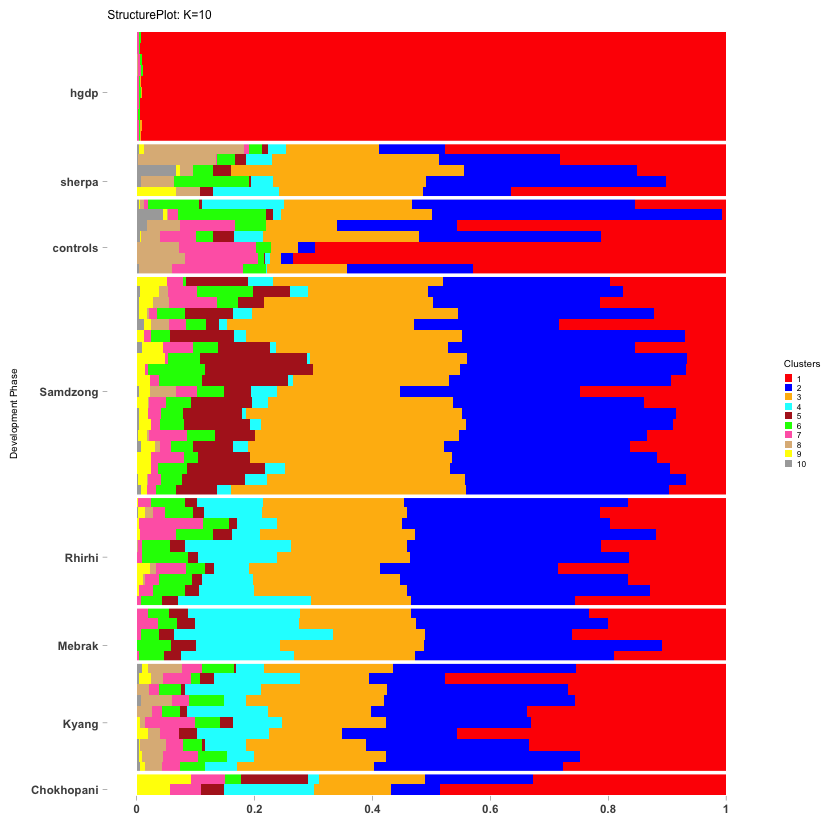

In [10]:
omega <- topic_clus$omega

annotation <- data.frame(
  sample_id = paste0("X", c(1:NROW(omega))),
  tissue_label = factor(labs, levels=c("Chokhopani", "Kyang", "Mebrak", "Rhirhi",
                                       "Samdzong", "controls", "sherpa", "hgdp"))
)



rownames(omega) <- annotation$sample_id;

cols1 <- c("red","blue","darkgoldenrod1","cyan","firebrick", "green",
           "hotpink","burlywood","yellow","darkgray","deepskyblue","darkkhaki",
           "brown4","darkorchid","magenta","yellow", "azure1","azure4")

CountClust::StructureGGplot(omega = omega,
                            annotation = annotation,
                            palette = cols1,
                            yaxis_label = "Development Phase",
                            order_sample = FALSE,
                            figure_title = paste0("StructurePlot: K=", dim(omega)[2]),
                            axis_tick = list(axis_ticks_length = .1,
                                             axis_ticks_lwd_y = .1,
                                             axis_ticks_lwd_x = .1,
                                             axis_label_size = 7,
                                             axis_label_face = "bold"))

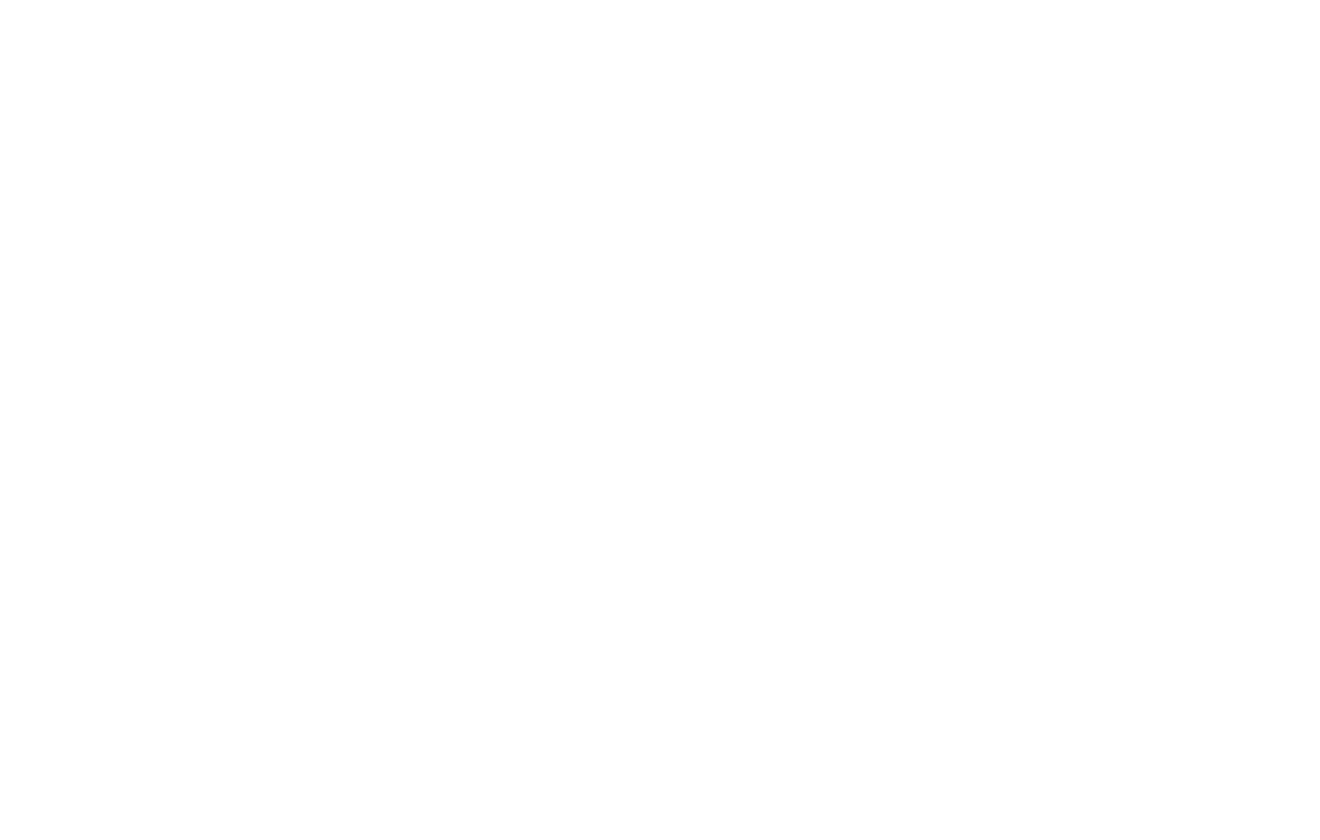

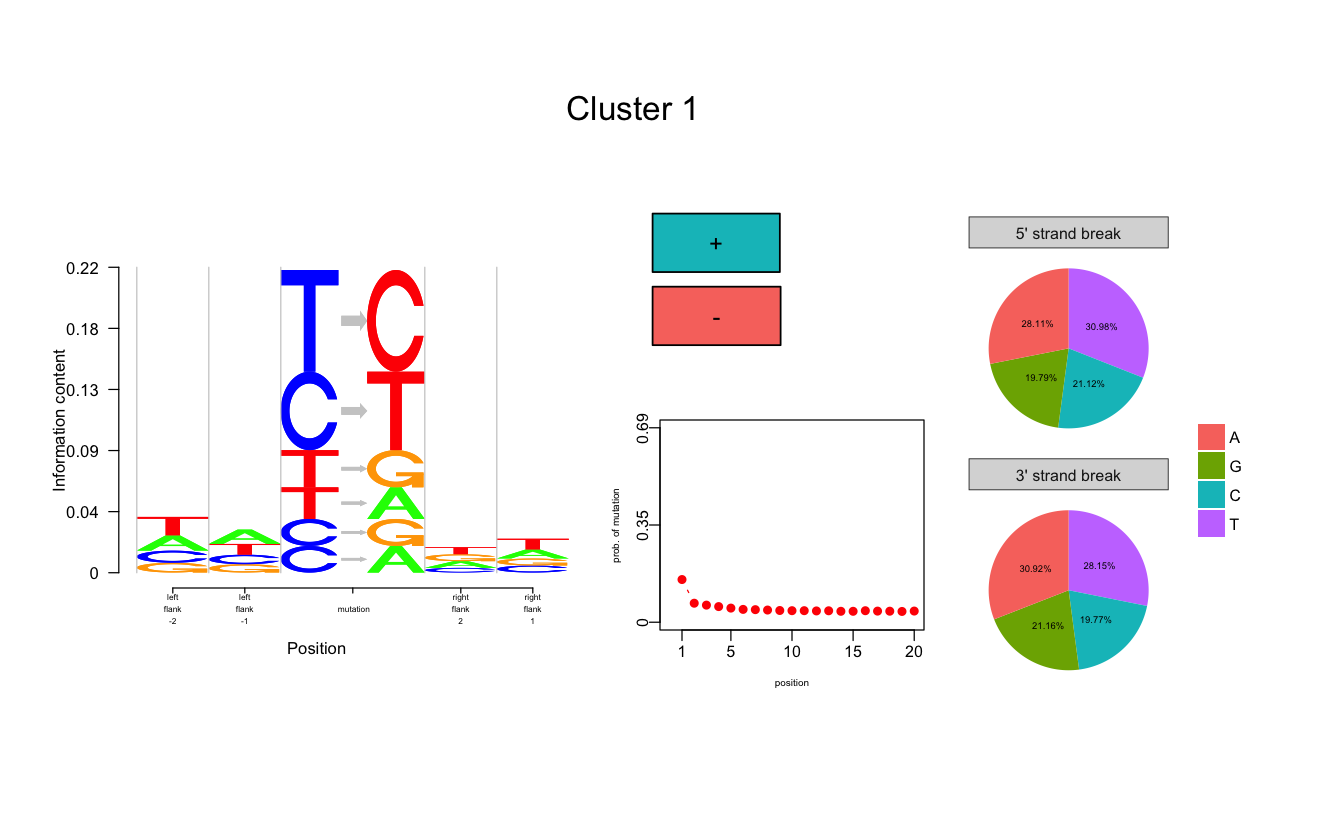

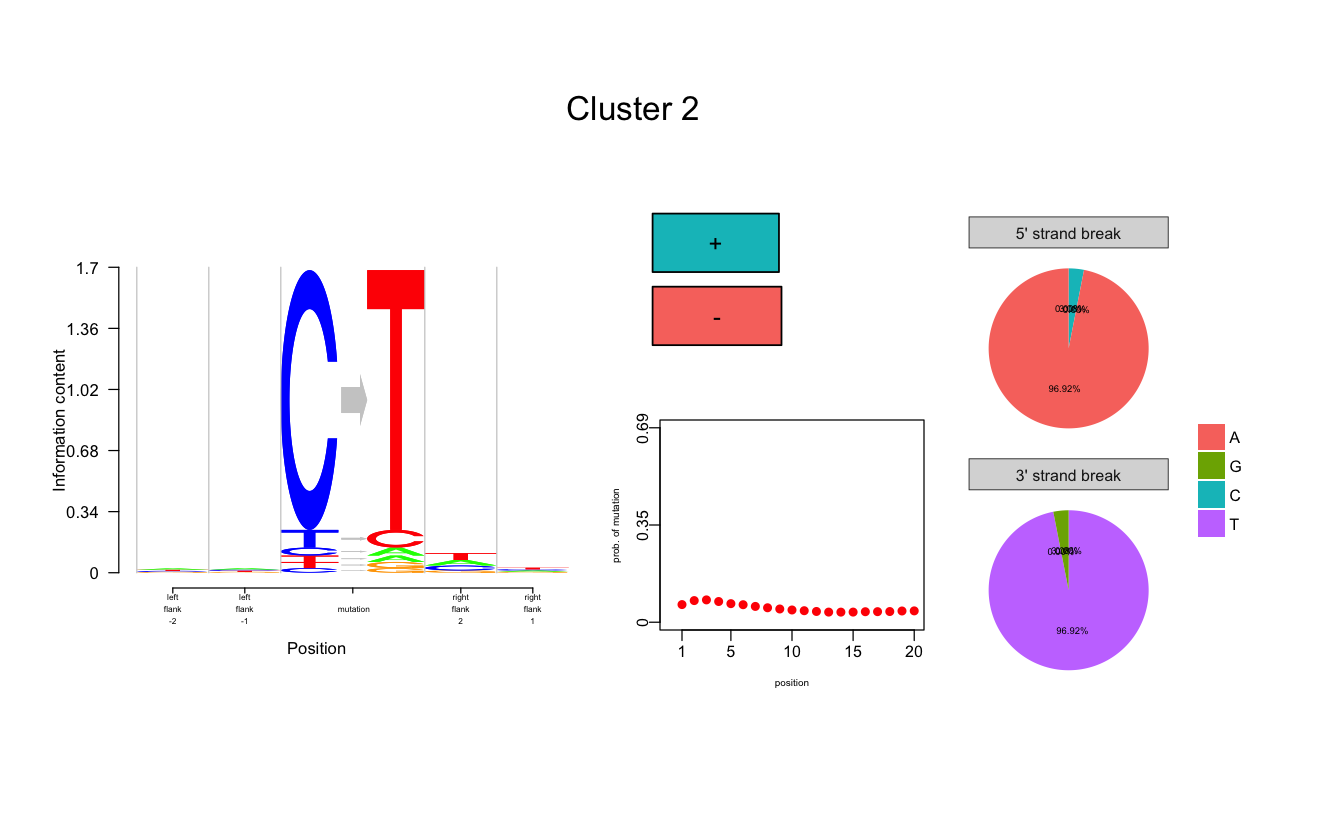

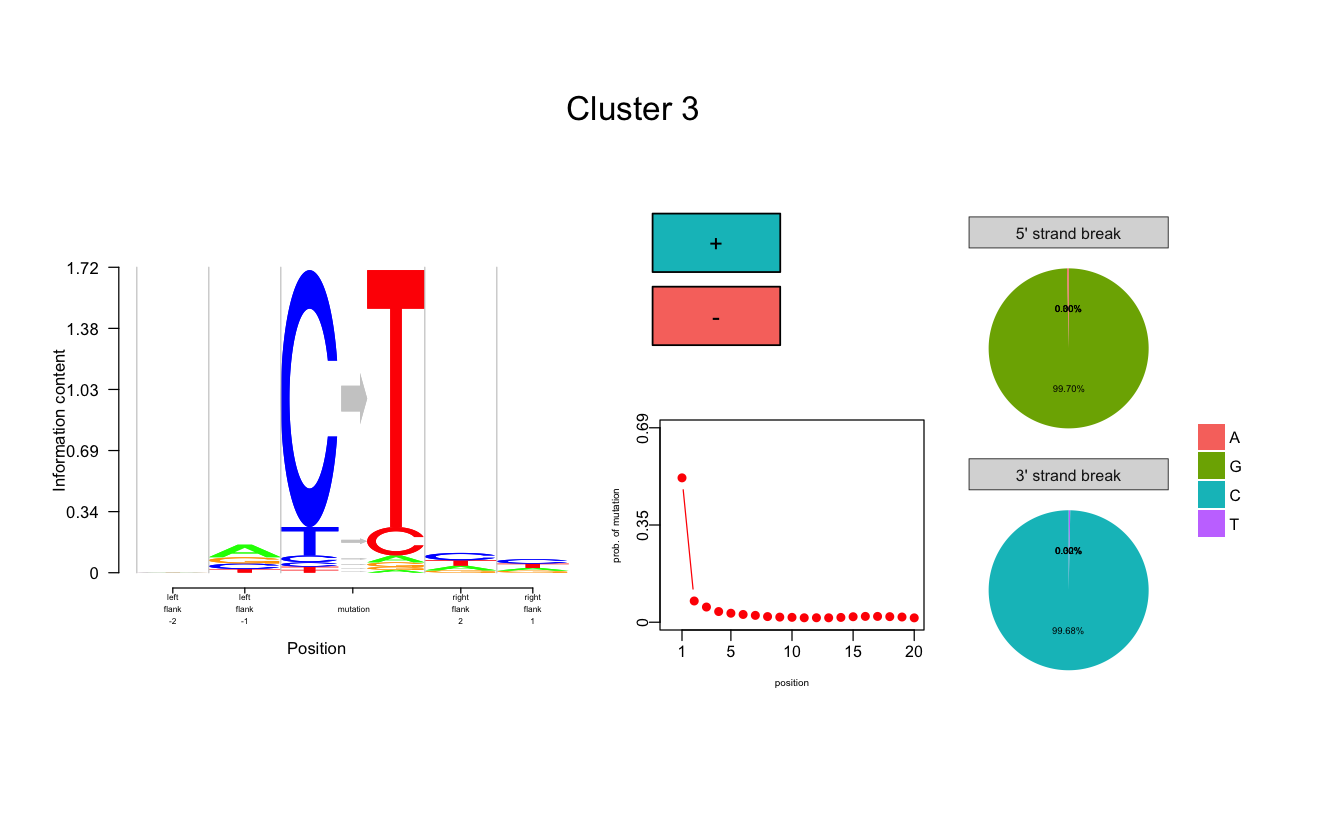

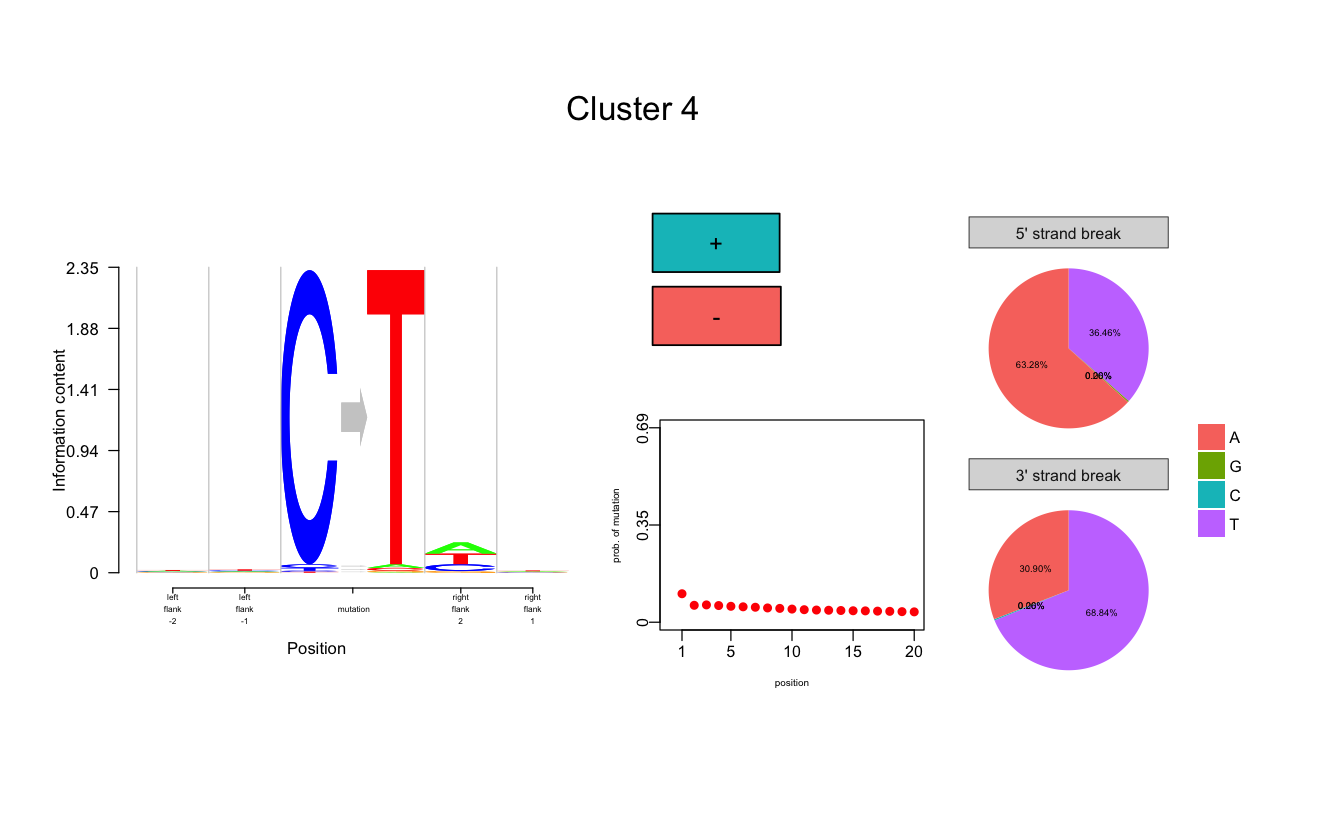

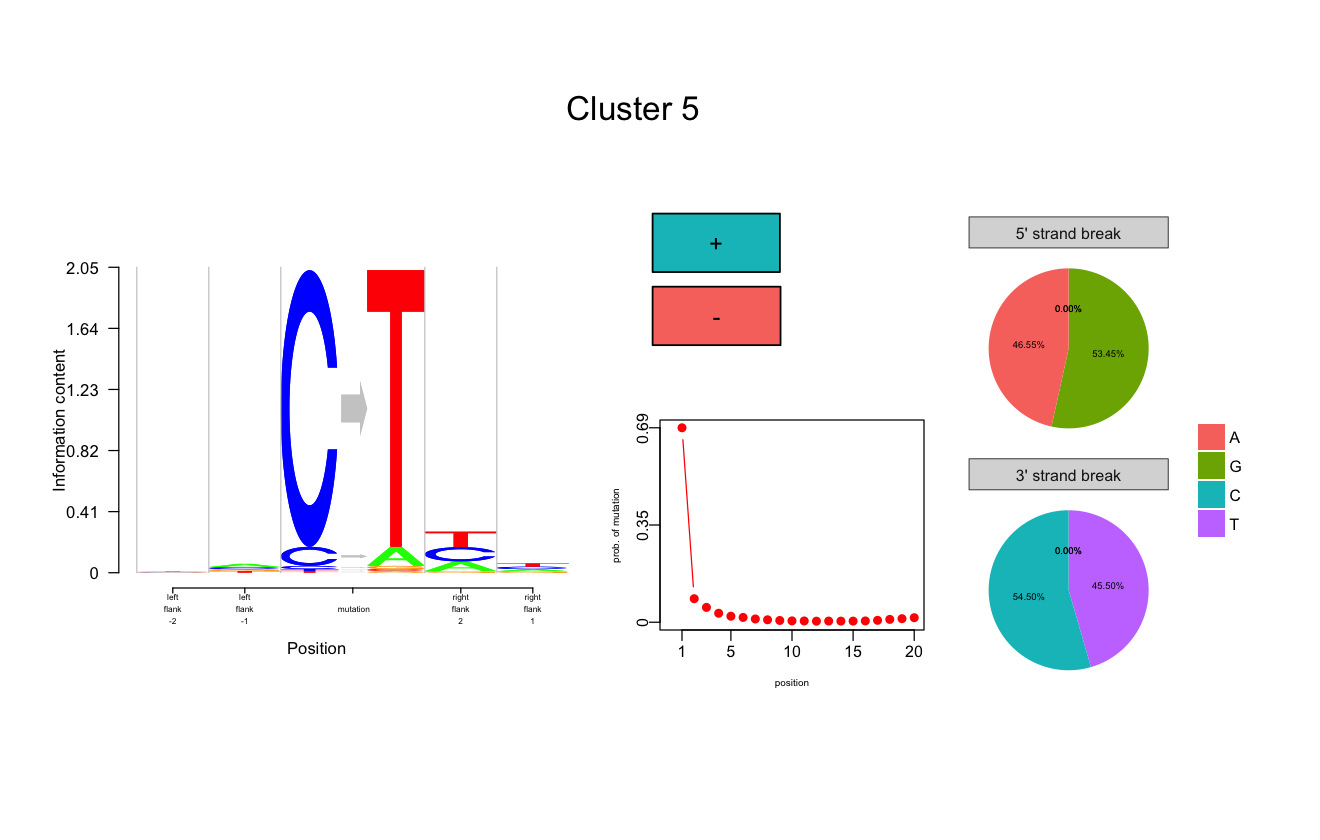

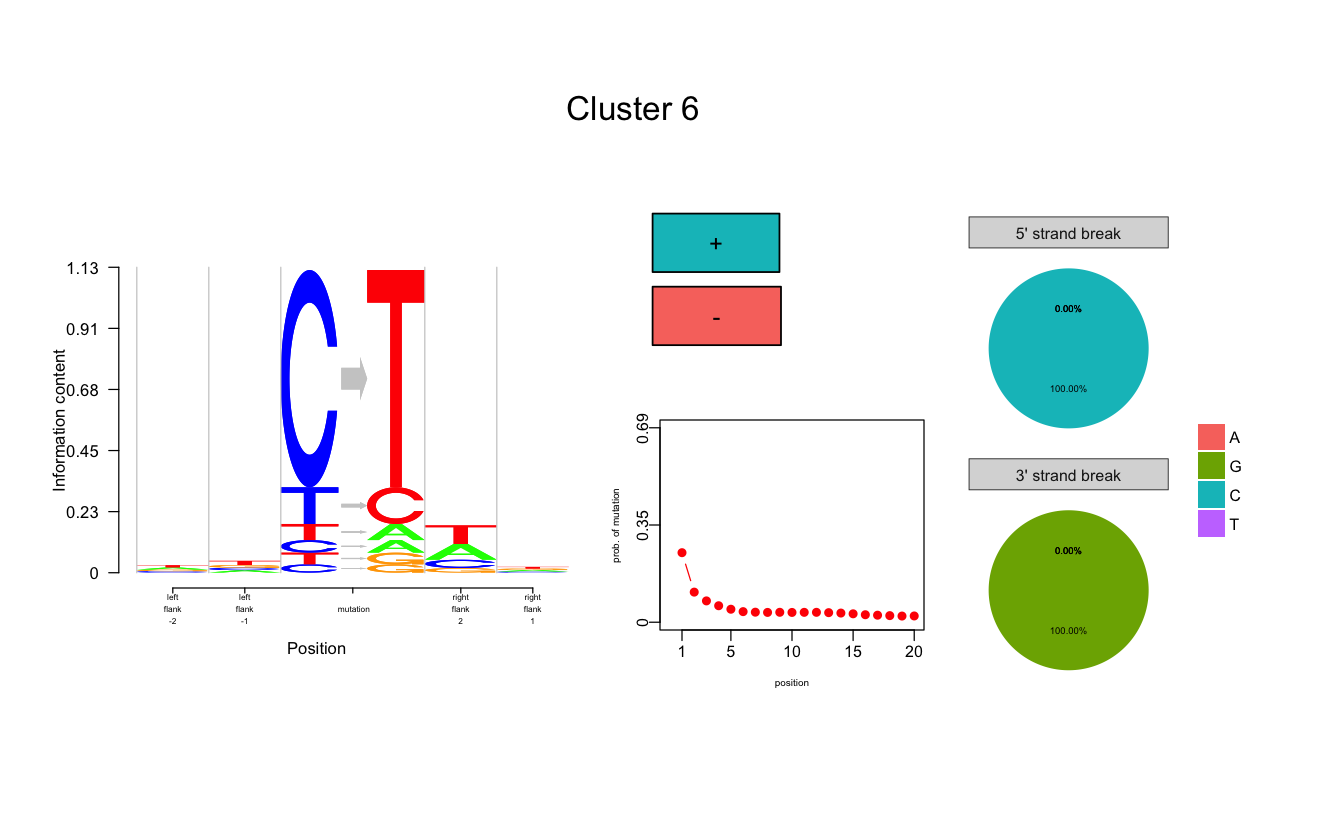

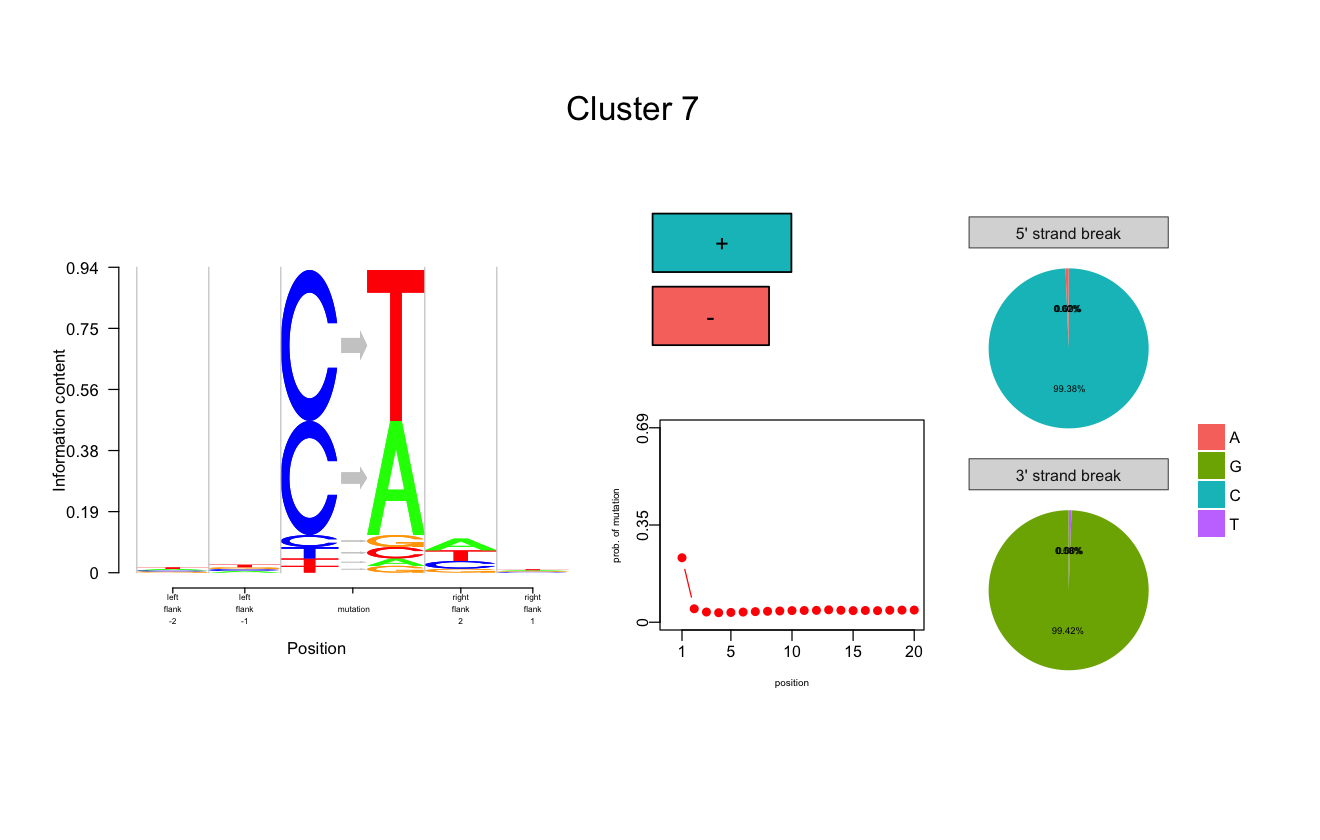

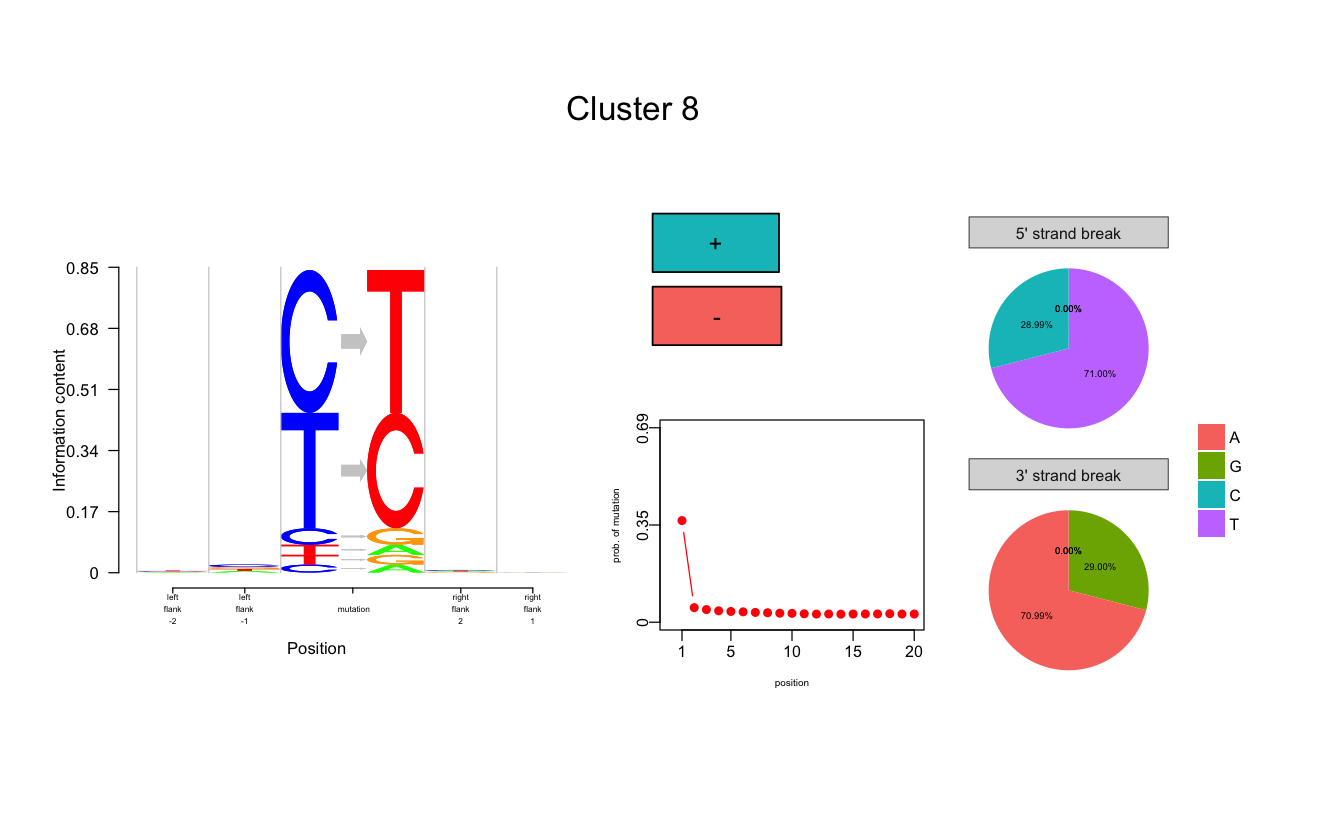

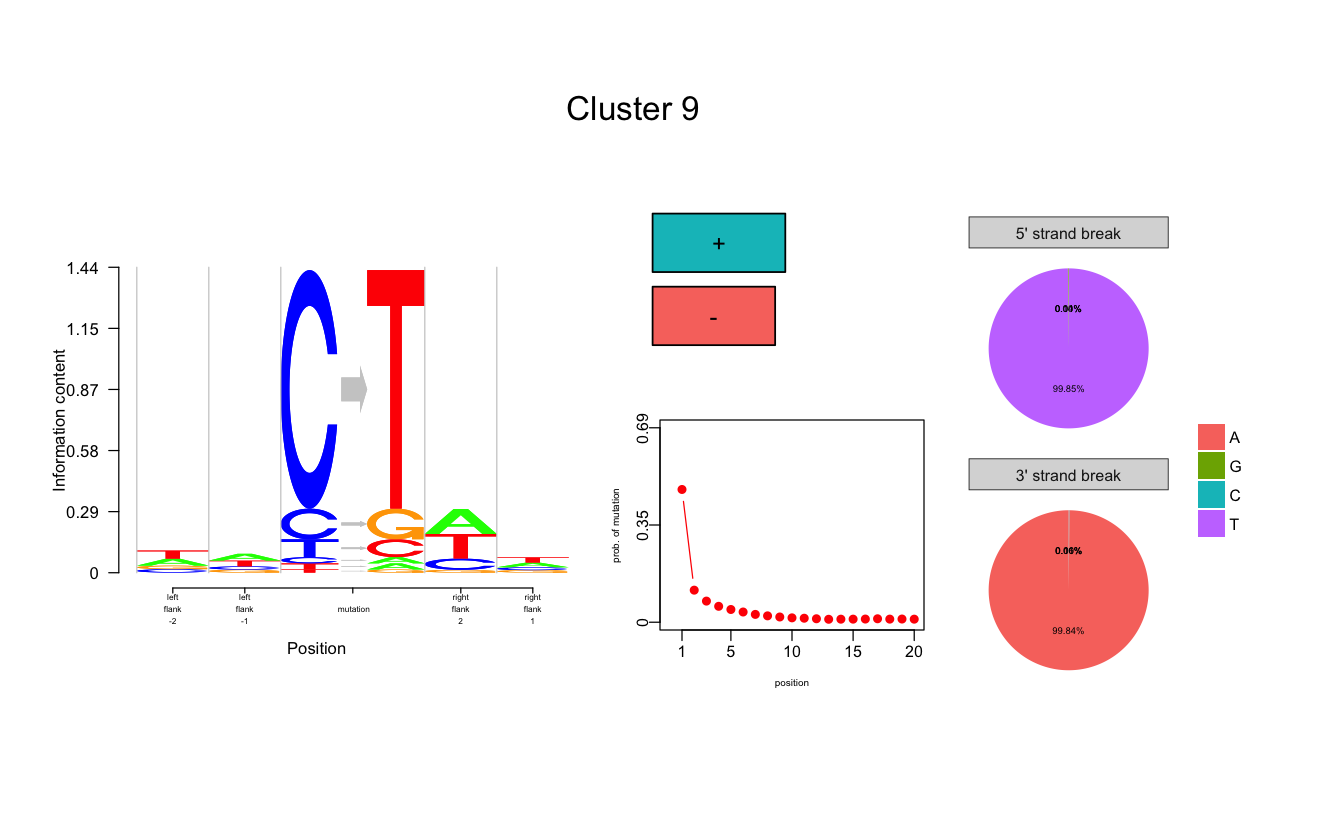

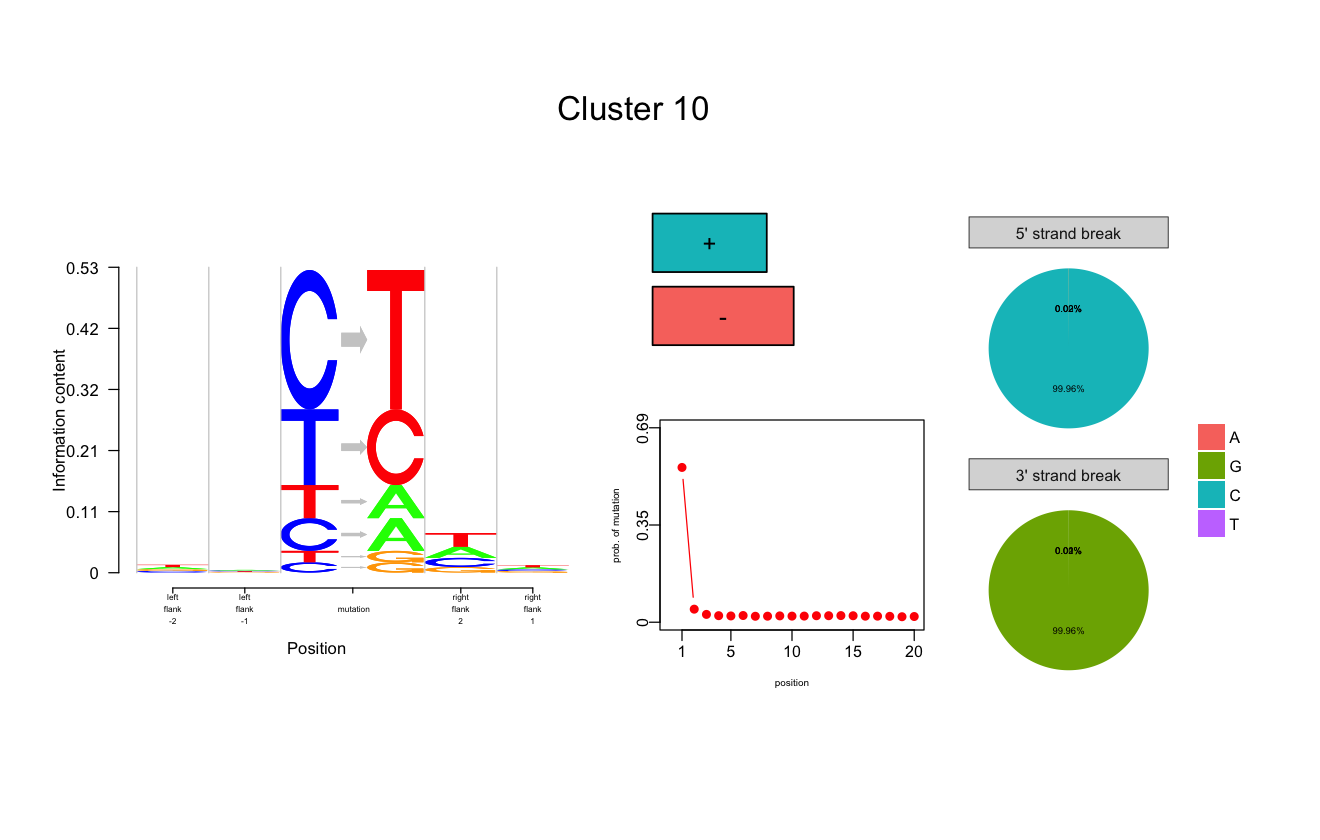

In [13]:
options(repr.plot.width=11, repr.plot.height=7)
plot.new()
damageLogo_pos_str(topic_clus$theta)

In [12]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: OS X 10.12 (Sierra)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] gridBase_0.4-7   maptpx_1.9-3     CountClust_0.1.2 ggplot2_2.2.1   
[5] aRchaic_0.99.0  

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.8         plyr_1.8.4          tools_3.3.1        
 [4] boot_1.3-18         digest_0.6.11       uuid_0.1-2         
 [7] nlme_3.1-128        jsonlite_1.2        evaluate_0.10      
[10] tibble_1.2          gtable_0.2.0        lattice_0.20-34    
[13] mgcv_1.8-16         Matrix_1.2-7.1      IRdisplay_0.4.4    
[16] DBI_0.5-1           IRkernel_0.7.1      parallel_3.3.1     
[19] gridExtra_2.2.1     cluster_2.0.5       repr_0.10          
[22] dplyr_0.5-1         stringr_1.1.0       gtools_3.5.0       
[25] stats4_3.3.1   